# Prepare

In [1]:
cd ../../../..

/home/majed_alshaibani/Experiments/DotlessArabic


In [2]:
import os
import random
import shutil
from pathlib import Path
from collections import defaultdict

import wandb
from tqdm.auto import tqdm

import torch
import torchmetrics
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule,Trainer
from pytorch_lightning.callbacks import EarlyStopping,LearningRateMonitor,ModelCheckpoint


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from dotless_arabic.processing import undot,process
from dotless_arabic.tokenizers import CharacterTokenizer
from dotless_arabic.experiments.nlms.src import constants
from dotless_arabic.datasets.poems.collect import collect_dataset_for_meter_classification

In [3]:
random.seed(42)
os.environ['WANDB_MODE']='disabled' #to disable wandb logging
os.environ['CUDA_LAUNCH_BLOCKING']='1' # to see CUDA errors
torch.cuda.empty_cache() # to free gpu memory
seed_everything(42, workers=True)
# other options: https://stackoverflow.com/questions/15197286/how-can-i-flush-gpu-memory-using-cuda-physical-reset-is-unavailable

Global seed set to 42


42

# Dataset Preparation

In [4]:
dataset = collect_dataset_for_meter_classification()

Found cached dataset parquet (/home/majed_alshaibani/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/majed_alshaibani/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-ac36c4a5e19cc65c.arrow


####################################################################################################
Number datasets samples:
254630
####################################################################################################
####################################################################################################
Number datasets samples after filtering non accepted meters:
144186
####################################################################################################


0it [00:00, ?it/s]

####################################################################################################
Sample of datasets samples:
أَصبَحَ المُلك لِلَّذي فَطر الخَل
قَ بِتَقديرٍ للعَزيز العَليمِ
غافر الذَنب للمسيءِ بِعَفوٍ
قابل التَوب ذي العَطاء العَميمِ
مُرسل المُصطَفى البَشير إِلَينا
رَحمة مِنهُ بِالكَلام القَديمِ
رَبَنا رَبّنا إِلَيكَ أَنينا
فَأَجرنا مِن حَر نار الجَحيمِ
وَاكفِنا شَرّ ما نَخاف بِلُطفٍ
يا عَظيماً يَرجى لِكُل عَظيمِ
####################################################################################################
####################################################################################################
Number of Baits:
1,794,858
####################################################################################################
####################################################################################################
Map meter names to classes:
####################################################################################################


  0%|          | 0/1794858 [00:00<?, ?it/s]

In [5]:
set(dataset.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [6]:
number_of_classes = len(set(dataset.values()))
number_of_classes

16

## Train-Test Split

In [7]:
dataset = {
    bait: meter_class
    for bait, meter_class in tqdm(dataset.items())
    if process(bait[0]).strip() and process(bait[1]).strip()
}
len(dataset)

  0%|          | 0/1794858 [00:00<?, ?it/s]

1786467

In [8]:
cap_threshold = 5_000

In [9]:
def cap_baits_dataset(dataset, threshold=cap_threshold):
    capped_dataset = {}
    meters_counts = defaultdict(int)
    for bait, meter_class in tqdm(dataset.items()):
        if meters_counts[meter_class] >= threshold:
            continue
        capped_dataset[bait] = meter_class
        meters_counts[meter_class] += 1
    return capped_dataset

In [10]:
dataset = cap_baits_dataset(dataset)
len(dataset)

  0%|          | 0/1786467 [00:00<?, ?it/s]

70958

In [11]:
baits = list(
    map(
        lambda bait: f"{process(bait[0])} # {process(bait[1])}",
        tqdm(dataset.keys()),
    )
)
meters = list(dataset.values())
len(baits), len(meters)

  0%|          | 0/70958 [00:00<?, ?it/s]

(70958, 70958)

Shuffle the dataset

In [12]:
zipped_dataset = list(zip(baits,meters))
random.shuffle(zipped_dataset)
baits,meters = list(map(list,zip(*zipped_dataset)))
baits[:10],meters[:10]

(['مشايخنا مصابكم عظيم # وصبركم لدى الجلى جسيم',
  'قالت الجوزاء حين رات # جفنه قد واصل السهرا',
  'اني رايت العز مستودعا # في خدمة الخلاق سبحانه',
  'كم عاث بالليل في الفراش على # كروم بستان شفرها',
  'قد صيرت سحبان في واىل # كانه عجماء صلصاله',
  'اوردوني منهلا اروي به # ظمىي او عللوي بالكذب',
  'لله فواد ملتهب # قد كاد يضيء توقده',
  'ولكم لام نصيح # في سليمى ونهاني',
  'وكل مفاضة تحكي غديرا # يعانق وهو مرتعد شمالا',
  'كفاك في اللاواء ينقع فيهما # ظما المطامع او صدا الخرصان'],
 [3, 1, 8, 9, 8, 7, 15, 7, 3, 6])

In [13]:
max_bait_length = len(max(baits,key=len))
# max_bait_length = 78
max_bait_length

82

In [14]:
x_train,x_test,y_train,y_test = train_test_split(baits,meters, test_size=0.05,random_state=42,shuffle=True,stratify=meters)
len(x_train),len(y_train),len(x_test),len(y_test)

(67410, 67410, 3548, 3548)

In [15]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=0.05,random_state=42,shuffle=True,stratify=y_train)
len(x_train),len(y_train),len(x_val),len(y_val)

(64039, 64039, 3371, 3371)

In [16]:
class BaitsDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        tokenizer,
        use_tqdm=True,
        undot_text=False,
    ):
        super().__init__()
        max_length = max_bait_length
        X = tqdm(X) if use_tqdm else dataset
        self.encoded_dataset = []
        self.X = X
        self.y = y
        for bait in X:
            if not bait:
                raise
            if undot_text:
                bait = undot(bait)
            tokenized_bait = tokenizer.tokenize_from_splits(bait)
            encoded_bait = []
            for token in tokenized_bait:
                encoded_bait.append(tokenizer.token_to_id(token))
            tokenizer.pad(encoded_bait,length=max_length)
            encoded_bait = encoded_bait[:max_length]
            self.encoded_dataset.append(encoded_bait)

    def __getitem__(self, index):
        inputs = torch.LongTensor(self.encoded_dataset[index])
        outputs = torch.LongTensor([self.y[index]])
        return inputs, outputs

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.encoded_dataset)

# Meter Classification Model

In [17]:
class LitMeterClassificationModel(LightningModule):
    def __init__(
        self,
        vocab_size,
        num_layers=5,
        gru_hiddens=256,
        gru_dropout=0.25,
        dropout_prob=0.333,
        learning_rate=0.001,
        embedding_size=256,
        number_of_classes=number_of_classes,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.gru_hiddens = gru_hiddens
        self.dropout_prob = dropout_prob
        self.learning_rate = learning_rate
        self.embedding_size = embedding_size
        self.number_of_classes = number_of_classes

        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=number_of_classes,
        )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=number_of_classes,
        )
        self.test_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=number_of_classes,
        )

        self.embedding_layer = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embedding_size,
        )
        self.gru_layer = nn.GRU(
            input_size=self.embedding_size,
            hidden_size=self.gru_hiddens,
            num_layers=self.num_layers,
            dropout=gru_dropout,
            batch_first=True,
            bidirectional=True,
        )
        self.first_dense_layer = nn.Linear(
            in_features=self.gru_hiddens,
            out_features=128,
        )
        self.dropout_layer = nn.Dropout(p=self.dropout_prob)
        self.relu = nn.ReLU()
        self.second_dense_layer = nn.Linear(
            in_features=128,
            out_features=self.number_of_classes,
        )

    def forward(self, x, hiddens=None):
        outputs = self.embedding_layer(x)
        outputs, hiddens = self.gru_layer(outputs)
        # https://stackoverflow.com/a/50914946/4412324
        outputs = (
            outputs[:, :, : self.gru_hiddens] + outputs[:, :, self.gru_hiddens :]
        )  # GRUs are bidirectional
        outputs = self.first_dense_layer(outputs)
        outputs = self.dropout_layer(outputs)
        outputs = self.relu(outputs)
        outputs = self.second_dense_layer(outputs)
        return outputs

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        labels = labels.squeeze()  # drop unnecessary dimention
        outputs = outputs[:, -1, :]  # take the results at the last time-step
        loss = F.cross_entropy(outputs, labels)
        train_accuracy = self.train_accuracy(outputs, labels)
        self.log(
            "loss",
            loss,
            on_step=True,
            on_epoch=False,
        )
        self.log(
            "train_acc",
            train_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        labels = labels.squeeze()  # drop unnecessary dimention
        outputs = outputs[:, -1, :]  # take the results at the last time-step
        loss = F.cross_entropy(outputs, labels)
        val_accuracy = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log(
            "val_acc",
            val_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}

    def predict_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        labels = labels.squeeze()  # drop unnecessary dimention
        outputs = outputs[:, -1, :]  # take the results at the last time-step
        preds = torch.argmax(
            F.softmax(outputs, dim=1),
            dim=1,
        )
        return labels,preds

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        labels = labels.squeeze()  # drop unnecessary dimention
        outputs = outputs[:, -1, :]  # take the results at the last time-step
        loss = F.cross_entropy(outputs, labels)
        test_accuracy = self.test_accuracy(outputs, labels)
        metrics = {"test_acc": test_accuracy, "test_loss": loss}
        self.log_dict(metrics, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.1,
            patience=2,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [18]:
lr_monitor = LearningRateMonitor(
    logging_interval="step",
    log_momentum=True,
)

In [19]:
wandb.login()

True

In [20]:
def get_best_checkpoint(text_type, tokenizer_class=CharacterTokenizer, checkpoints_base_path="MeterClassification"):
    checkpoints_path = (
        f"{checkpoints_base_path}/{text_type}/{tokenizer_class.__name__}/{cap_threshold}/checkpoints"
    )
    for file_name in os.listdir(checkpoints_path):
        if file_name.startswith("epoch"):
            return f"{checkpoints_path}/{file_name}"

In [21]:
batch_size = 512
epochs = 100

# Dotted Experiment

In [22]:
with open("tmp_dataset2.txt", "w") as f:
    f.write("\n".join(item for item in x_train))
dotted_tokenizer = CharacterTokenizer(special_tokens=['#','<##>'])
dotted_tokenizer.train('tmp_dataset2.txt')

Training CharacterTokenizer ...


In [23]:
train_dataset = BaitsDataset(X=x_train,y=y_train,tokenizer=dotted_tokenizer)

  0%|          | 0/64039 [00:00<?, ?it/s]

In [24]:
val_dataset = BaitsDataset(X=x_val,y=y_val,tokenizer=dotted_tokenizer)

  0%|          | 0/3371 [00:00<?, ?it/s]

In [25]:
test_dataset = BaitsDataset(X=x_test,y=y_test,tokenizer=dotted_tokenizer)

  0%|          | 0/3548 [00:00<?, ?it/s]

In [26]:
dotted_tokenizer.vocab_size

35

In [27]:
train_dataloader = DataLoader(
    shuffle=True,
    dataset=train_dataset,
    num_workers=32,
    drop_last=True,
    batch_size=batch_size,
)

In [28]:
val_dataloader = DataLoader(
    shuffle=False,
    dataset=val_dataset,
    num_workers=32,
    drop_last=True,
    batch_size=batch_size,
)

In [29]:
test_dataloader = DataLoader(
    shuffle=False,
    dataset=test_dataset,
    num_workers=32,
    drop_last=True,
    batch_size=batch_size,
)

In [30]:
model = LitMeterClassificationModel(
    vocab_size=dotted_tokenizer.vocab_size,
    dropout_prob=0.15,
)
model

LitMeterClassificationModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding_layer): Embedding(35, 256)
  (gru_layer): GRU(256, 256, num_layers=5, batch_first=True, dropout=0.25, bidirectional=True)
  (first_dense_layer): Linear(in_features=256, out_features=128, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (second_dense_layer): Linear(in_features=128, out_features=16, bias=True)
)

In [31]:
shutil.rmtree(
    Path(
        f"MeterClassification/dotted/{dotted_tokenizer.__class__.__name__}/{cap_threshold}/checkpoints"
    ),
    ignore_errors=True,
)
checkpoint_callback = ModelCheckpoint(
    mode="min",
    save_top_k=1,
    verbose=False,
    save_last=False,
    monitor="val_loss",
    save_weights_only=False,
    auto_insert_metric_name=True,
    save_on_train_epoch_end=False,
    filename="{epoch}-{val_loss:.3f}-{step}",
    dirpath=f"MeterClassification/dotted/{dotted_tokenizer.__class__.__name__}/{cap_threshold}/checkpoints",
)

In [32]:
wandb_logger = WandbLogger(
    project="MC",
    name=f"dotted_{dotted_tokenizer.__class__.__name__}-{cap_threshold}",
    reinit=True,
)
wandb_logger.watch(model, log="all")

In [33]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.05,
    patience=20,
    check_finite=True,
)

In [34]:
trainer = Trainer(
    max_epochs=epochs,
    devices=[0],
    deterministic=True,
    logger=wandb_logger,
    val_check_interval=0.5,
    accelerator="cuda",
    log_every_n_steps=max(len(train_dataloader) // 25, 1),
    # default_root_dir=f"LMsModels/{previous_hiddens}",
    callbacks=[
        checkpoint_callback,
        early_stopping_callback,
        lr_monitor,
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
trainer.validate(
    model=model,
    dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.7717959880828857     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 2.7717959880828857}]

In [36]:
trainer.fit(model,train_dataloader,val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type               | Params
----------------------------------------------------------
0 | train_accuracy     | MulticlassAccuracy | 0     
1 | val_accuracy       | MulticlassAccuracy | 0     
2 | test_accuracy      | MulticlassAccuracy | 0     
3 | embedding_layer    | Embedding          | 9.0 K 
4 | gru_layer          | GRU                | 5.5 M 
5 | first_dense_layer  | Linear             | 32.9 K
6 | dropout_layer      | Dropout            | 0     
7 | relu               | ReLU               | 0     
8 | second_dense_layer | Linear             | 2.1 K 
----------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.257    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [37]:
model = LitMeterClassificationModel.load_from_checkpoint(
    get_best_checkpoint(text_type="dotted")
)
model

LitMeterClassificationModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding_layer): Embedding(35, 256)
  (gru_layer): GRU(256, 256, num_layers=5, batch_first=True, dropout=0.25, bidirectional=True)
  (first_dense_layer): Linear(in_features=256, out_features=128, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (second_dense_layer): Linear(in_features=128, out_features=16, bias=True)
)

In [38]:
trainer.test(model,test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9016926884651184     │
│         test_loss         │    0.4075472056865692     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9016926884651184, 'test_loss': 0.4075472056865692}]

In [39]:
predictions,labels = list(),list()
for batch_predictions,batch_labels in trainer.predict(model,test_dataloader):
    predictions.extend(batch_predictions.tolist())
    labels.extend(batch_labels.tolist())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 124it [00:00, ?it/s]

In [40]:
predictions = torch.tensor(predictions)
labels = torch.tensor(labels)
predictions.shape,labels.shape

(torch.Size([3548]), torch.Size([3548]))

In [41]:
test_confusion_matrix = torchmetrics.ConfusionMatrix(
    task="multiclass",
    num_classes=len(set(labels.tolist())),
)(predictions, labels)

<Axes: >

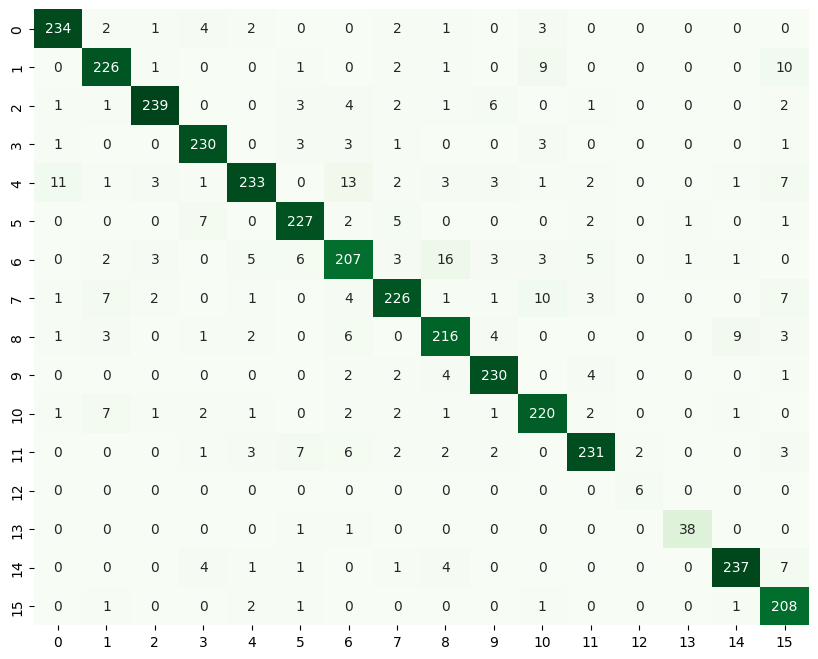

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(test_confusion_matrix,annot=True,cmap='Greens',fmt='g',cbar=False)

In [ ]:
wandb.finish()

# Dotless Experiment

In [22]:
with open("tmp_dataset2.txt", "w") as f:
    f.write("\n".join(undot(item) for item in tqdm(x_train)))
dotless_tokenizer = CharacterTokenizer(special_tokens=['#','<##>'])
dotless_tokenizer.train('tmp_dataset2.txt')

  0%|          | 0/64039 [00:00<?, ?it/s]

Training CharacterTokenizer ...


In [23]:
train_dataset = BaitsDataset(
    X=x_train,
    y=y_train,
    tokenizer=dotless_tokenizer,
    undot_text=True,
)

  0%|          | 0/64039 [00:00<?, ?it/s]

In [24]:
val_dataset = BaitsDataset(
    X=x_val,
    y=y_val,
    tokenizer=dotless_tokenizer,
    undot_text=True,
)

  0%|          | 0/3371 [00:00<?, ?it/s]

In [25]:
test_dataset = BaitsDataset(
    X=x_test,
    y=y_test,
    tokenizer=dotless_tokenizer,
    undot_text=True,
)

  0%|          | 0/3548 [00:00<?, ?it/s]

In [26]:
dotless_tokenizer.vocab_size

23

In [27]:
train_dataloader = DataLoader(
    shuffle=True,
    dataset=train_dataset,
    num_workers=32,
    drop_last=True,
    batch_size=batch_size,
)

In [28]:
val_dataloader = DataLoader(
    shuffle=False,
    dataset=val_dataset,
    num_workers=32,
    drop_last=True,
    batch_size=batch_size,
)

In [29]:
test_dataloader = DataLoader(
    shuffle=False,
    dataset=test_dataset,
    num_workers=32,
    drop_last=True,
    batch_size=batch_size,
)

In [30]:
shutil.rmtree(
    Path(
        f"MeterClassification/dotless/{dotless_tokenizer.__class__.__name__}/{cap_threshold}/checkpoints"
    ),
    ignore_errors=True,
)
checkpoint_callback = ModelCheckpoint(
    mode="min",
    save_top_k=1,
    verbose=False,
    save_last=False,
    monitor="val_loss",
    save_weights_only=False,
    auto_insert_metric_name=True,
    save_on_train_epoch_end=False,
    filename="{epoch}-{val_loss:.3f}-{step}",
    dirpath=f"MeterClassification/dotless/{dotless_tokenizer.__class__.__name__}/{cap_threshold}/checkpoints",
)

In [31]:
model = LitMeterClassificationModel(
    # num_layers=3,
    # gru_hiddens=128,
    # embedding_size=128,
    dropout_prob=0.15,
    # gru_dropout=0.2,
    vocab_size=dotless_tokenizer.vocab_size,
)
model

LitMeterClassificationModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding_layer): Embedding(23, 256)
  (gru_layer): GRU(256, 256, num_layers=5, batch_first=True, dropout=0.25, bidirectional=True)
  (first_dense_layer): Linear(in_features=256, out_features=128, bias=True)
  (dropout_layer): Dropout(p=0.15, inplace=False)
  (relu): ReLU()
  (second_dense_layer): Linear(in_features=128, out_features=16, bias=True)
)

In [32]:
wandb_logger = WandbLogger(
    project="MC",
    name=f"dotless_{dotless_tokenizer.__class__.__name__}-{cap_threshold}",
    reinit=True,
)
wandb_logger.watch(model, log="all")

In [33]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.05,
    patience=20,
    check_finite=True,
)

In [34]:
trainer = Trainer(
    max_epochs=epochs,
    devices=[0],
    deterministic=True,
    logger=wandb_logger,
    val_check_interval=0.5,
    accelerator="cuda",
    log_every_n_steps=max(len(train_dataloader) // 25, 1),
    # default_root_dir=f"LMsModels/{previous_hiddens}",
    callbacks=[
        checkpoint_callback,
        early_stopping_callback,
        lr_monitor,
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
trainer.validate(
    model=model,
    dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.773846387863159     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 2.773846387863159}]

In [36]:
trainer.fit(model,train_dataloader,val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type               | Params
----------------------------------------------------------
0 | train_accuracy     | MulticlassAccuracy | 0     
1 | val_accuracy       | MulticlassAccuracy | 0     
2 | test_accuracy      | MulticlassAccuracy | 0     
3 | embedding_layer    | Embedding          | 5.9 K 
4 | gru_layer          | GRU                | 5.5 M 
5 | first_dense_layer  | Linear             | 32.9 K
6 | dropout_layer      | Dropout            | 0     
7 | relu               | ReLU               | 0     
8 | second_dense_layer | Linear             | 2.1 K 
----------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.245    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [37]:
model = LitMeterClassificationModel.load_from_checkpoint(
    get_best_checkpoint(text_type="dotless")
)
model

LitMeterClassificationModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding_layer): Embedding(23, 256)
  (gru_layer): GRU(256, 256, num_layers=5, batch_first=True, dropout=0.25, bidirectional=True)
  (first_dense_layer): Linear(in_features=256, out_features=128, bias=True)
  (dropout_layer): Dropout(p=0.15, inplace=False)
  (relu): ReLU()
  (second_dense_layer): Linear(in_features=128, out_features=16, bias=True)
)

In [38]:
trainer.test(model,test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9078776240348816     │
│         test_loss         │     0.384741872549057     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9078776240348816, 'test_loss': 0.384741872549057}]

In [39]:
predictions,labels = list(),list()
for batch_predictions,batch_labels in trainer.predict(model,test_dataloader):
    predictions.extend(batch_predictions.tolist())
    labels.extend(batch_labels.tolist())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 124it [00:00, ?it/s]

In [40]:
predictions = torch.tensor(predictions)
labels = torch.tensor(labels)
predictions.shape,labels.shape

(torch.Size([3548]), torch.Size([3548]))

In [41]:
test_confusion_matrix = torchmetrics.ConfusionMatrix(
    task="multiclass",
    num_classes=len(set(labels.tolist())),
)(predictions, labels)

<Axes: >

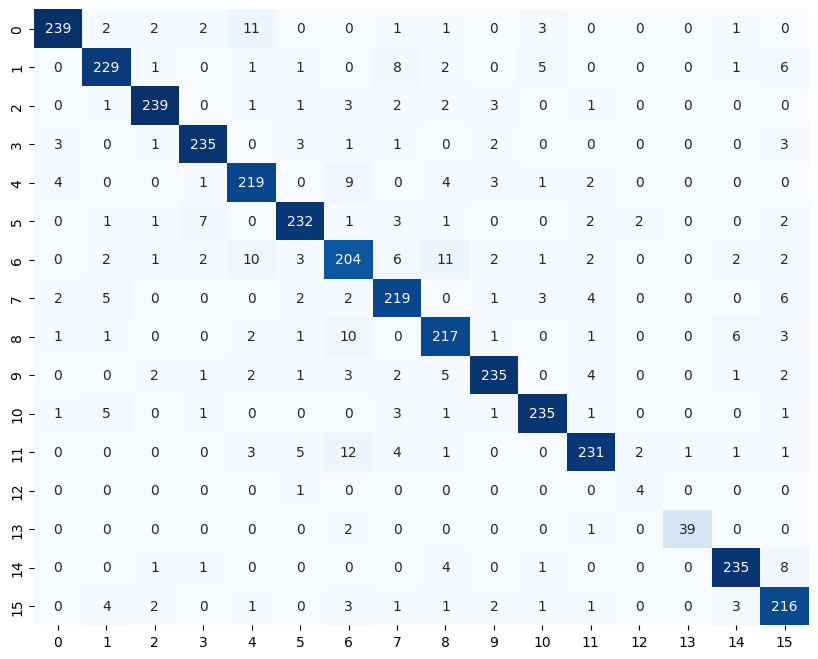

In [42]:
plt.figure(figsize = (10,8))
sns.heatmap(test_confusion_matrix,annot=True,cmap='Blues',fmt='g',cbar=False)

In [43]:
wandb.finish()